In [ ]:
!pip install datasets pillow tqdm timm scikit-learn pywavelets opencv-python-headless

import os
from google.colab import drive

# Mount your Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully.


In [ ]:
# Assuming your dataset is in your Google Drive at the specified paths

DRIVE_PATH = "/content/drive/MyDrive/AI gen Images/archive"
SAMPLED_REAL_DIR = os.path.join(DRIVE_PATH, "AiArtData/AiArtData")
SAMPLED_AI_DIR = os.path.join(DRIVE_PATH, "RealArt/RealArt")

print(f"Real images path: {SAMPLED_REAL_DIR}")
print(f"Fake images path: {SAMPLED_AI_DIR}")

Real images path: /content/drive/MyDrive/AI gen Images/archive/AiArtData/AiArtData
Fake images path: /content/drive/MyDrive/AI gen Images/archive/RealArt/RealArt


Cell 5: Define Forensic Image Preprocessing Functions

In [ ]:
import numpy as np
import pywt
import cv2
from PIL import Image, ImageChops, ImageEnhance
import io

def apply_fft(img_pil):
    """Computes the FFT magnitude spectrum and returns as a PIL Image."""
    img_gray = np.array(img_pil.convert('L'))
    f_transform = np.fft.fft2(img_gray)
    f_transform_shifted = np.fft.fftshift(f_transform)
    # Add epsilon to avoid log(0)
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted) + 1e-8)
    # Normalize to 0-255 range for image conversion
    cv2.normalize(magnitude_spectrum, magnitude_spectrum, 0, 255, cv2.NORM_MINMAX)
    return Image.fromarray(magnitude_spectrum.astype(np.uint8))

def apply_wavelet_transform(img_pil, wavelet='db1'):
    """Computes Wavelet transform and returns a PIL Image of high-freq components."""
    img_gray = np.array(img_pil.convert('L'))
    coeffs = pywt.dwt2(img_gray, wavelet)
    cA, (cH, cV, cD) = coeffs

    # Normalize high-frequency components for visualization
    cD = cv2.normalize(cD, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # We only care about high-freq details, let's return the diagonal component
    return Image.fromarray(cD)

def apply_ela(img_pil, quality=90, scale=15):
    """Performs Error Level Analysis and returns a PIL Image."""
    buffer = io.BytesIO()
    img_pil.save(buffer, 'JPEG', quality=quality)
    resaved_img = Image.open(buffer).convert('RGB')

    ela_img = ImageChops.difference(img_pil, resaved_img)

    # Enhance the contrast to make differences more visible
    enhancer = ImageEnhance.Brightness(ela_img)
    ela_img_enhanced = enhancer.enhance(scale)

    return ela_img_enhanced

print("Forensic preprocessing functions defined.")

Forensic preprocessing functions defined.


Cell 6: Define the "V2" Dataset (with Augmentation & Transparency Fix)
This cell defines the custom PyTorch Dataset class that will load your images and all their forensic versions.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import glob
import random
import os

class MultiForensicDatasetV2(Dataset):
    def __init__(self, ai_dir, real_dir, transform_rgb, transform_forensic, is_train=True):
        self.transform_rgb = transform_rgb
        self.transform_forensic = transform_forensic
        self.is_train = is_train

        # Load image paths and assign labels (1 for AI, 0 for Real)
        ai_images = [(path, 1) for path in glob.glob(os.path.join(ai_dir, "*.[jp][pn]g"))]
        real_images = [(path, 0) for path in glob.glob(os.path.join(real_dir, "*.[jp][pn]g"))]
        self.all_images = ai_images + real_images

        random.shuffle(self.all_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]

        try:
            img_pil = Image.open(img_path)

            # --- Fix for Transparency/Palette Issues ---
            if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
                background = Image.new('RGB', img_pil.size, (255, 255, 255))
                background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
                img_pil = background
            else:
                img_pil = img_pil.convert('RGB')

            # Apply forensic functions (from Cell 3)
            fft_img = apply_fft(img_pil).convert('L')
            wavelet_img = apply_wavelet_transform(img_pil).convert('L')
            ela_img = apply_ela(img_pil).convert('L') # Use grayscale ELA

            # Apply transforms (augmentation for train, simple for val)
            rgb_tensor = self.transform_rgb(img_pil)
            fft_tensor = self.transform_forensic(fft_img)
            wavelet_tensor = self.transform_forensic(wavelet_img)
            ela_tensor = self.transform_forensic(ela_img)

            return {
                'rgb': rgb_tensor,
                'fft': fft_tensor,
                'wavelet': wavelet_tensor,
                'ela': ela_tensor,
                'label': torch.tensor(label, dtype=torch.float32)
            }

        except Exception as e:
            print(f"\nWarning: Error loading {img_path}: {e}. Skipping.")
            # Try next index to avoid breaking the batch
            return self.__getitem__((idx + 1) % len(self))

print("MultiForensicDatasetV2 class defined.")

MultiForensicDatasetV2 class defined.


Cell 7: Define the "V2" Model (with Dropout Regularization)
This cell defines your advanced HybridForensicsNetV2 model architecture.

In [ ]:
import torch
import torch.nn as nn
import timm

class HybridForensicsNetV2(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.3):
        super(HybridForensicsNetV2, self).__init__()

        # --- 1. Define the four stems ---
        # RGB Stem (3 input channels)
        self.rgb_stem = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)

        # Forensic Stems (1 input channel)
        self.fft_stem = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, in_chans=1)
        self.wavelet_stem = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, in_chans=1)
        self.ela_stem = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, in_chans=1)

        # --- 2. Get feature dimension ---
        feature_dim = self.rgb_stem.num_features
        total_feature_dim = feature_dim * 4 # 4 stems

        # --- 3. Define the Fusion Layer and Classifier ---
        self.fusion_layer = nn.Sequential(
            nn.Linear(total_feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # Get inputs
        rgb_in = x['rgb']
        fft_in = x['fft']
        wavelet_in = x['wavelet']
        ela_in = x['ela']

        # --- 1. Pass each input through its stem ---
        rgb_features = self.rgb_stem(rgb_in)
        fft_features = self.fft_stem(fft_in)
        wavelet_features = self.wavelet_stem(wavelet_in)
        ela_features = self.ela_stem(ela_in)

        # --- 2. Concatenate all features ---
        combined_features = torch.cat([
            rgb_features,
            fft_features,
            wavelet_features,
            ela_features
        ], dim=1)

        # --- 3. Pass through fusion and classifier ---
        fused_output = self.fusion_layer(combined_features)
        final_output = self.classifier(fused_output)

        return final_output

print("HybridForensicsNetV2 class defined.")

HybridForensicsNetV2 class defined.


Cell 8: Define Training & Validation Functions (with AMP Fix)
This cell defines the helper functions that run the training and validation loops.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch.amp # Import for Automatic Mixed Precision

def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        labels = batch['label'].to(device).unsqueeze(1)

        optimizer.zero_grad()

        # Use Automatic Mixed Precision (AMP)
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scale the loss and backpropagate
        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # Standard backpropagation for CPU
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * labels.size(0)
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device).unsqueeze(1)

            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_labels.extend(labels.cpu().numpy().astype(int))
            all_preds.extend(preds)
            all_probs.extend(probs)

    epoch_loss = running_loss / len(dataloader.dataset)

    # Calculate metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    try:
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        acc = accuracy_score(all_labels, all_preds)
        prec, rec, f1, auc = 0, 0, 0, 0.5
        print("Warning: Error in metric calculation (likely single-class batch).")

    return epoch_loss, acc, prec, rec, f1, auc, all_labels, all_preds

print("Training and validation functions defined (with AMP).")

Training and validation functions defined (with AMP).


Cell 9: Model Training Configuration
This cell sets up all the hyperparameters, data augmentations, DataLoaders, and the model for training.

In [ ]:
import torch.cuda.amp  # **FIX 1: Import for GradScaler**

# --- Model Hyperparameters ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
TEST_SPLIT = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Define Data Augmentations ---
train_transforms = {
    'rgb': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'forensic': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

val_transforms = {
    'rgb': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'forensic': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# --- Create Datasets and DataLoaders ---
print("--- Preparing DataLoaders for WildFake Sample ---")
train_dataset_v2 = MultiForensicDatasetV2(SAMPLED_AI_DIR, SAMPLED_REAL_DIR, train_transforms['rgb'], train_transforms['forensic'], is_train=True)
val_dataset_v2 = MultiForensicDatasetV2(SAMPLED_AI_DIR, SAMPLED_REAL_DIR, val_transforms['rgb'], val_transforms['forensic'], is_train=False)

dataset_size = len(train_dataset_v2)
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
random.seed(42)
random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_subset = Subset(train_dataset_v2, train_indices)
val_subset = Subset(val_dataset_v2, val_indices)

# **FIX 2: Make pin_memory conditional on CUDA**
pin_mem = (device.type == 'cuda')

train_loader_v2 = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=pin_mem)
val_loader_v2 = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin_mem)

print(f"Total images: {dataset_size}")
print(f"V2 Train subset size: {len(train_subset)}")
print(f"V2 Val subset size: {len(val_subset)}")

print("\n--- Initializing V2 Model ---")
model_v2 = HybridForensicsNetV2().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_v2.parameters(), lr=LEARNING_RATE)

# **FIX 1 (continued): Correctly initialize GradScaler**
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# --- Define Save Path ---
WILDFAKE_OUTPUT_DIR = os.path.join(DRIVE_PATH, "WildFake_Output")
os.makedirs(WILDFAKE_OUTPUT_DIR, exist_ok=True)
model_save_path_v2 = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_hybrid_model_best.pth")

print(f"Device: {device}")
print(f"Model save path: {model_save_path_v2}")
print("Configuration complete. Ready to train.")

--- Preparing DataLoaders for WildFake Sample ---
Total images: 911
V2 Train subset size: 729
V2 Val subset size: 182

--- Initializing V2 Model ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Device: cuda
Model save path: /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth
Configuration complete. Ready to train.


/tmp/ipython-input-3670188468.py:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


Cell 10: Train the Model on WildFake
This is the cell that runs the actual training loop. It will take some time.

Starting training for HybridForensicsNetV2 on WildFake...


Training:  57%|█████▋    | 13/23 [02:42<01:30,  9.07s/it, loss=0.546]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  91%|█████████▏| 21/23 [04:00<00:15,  7.96s/it, loss=0.53]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20 | Train Loss: 0.6225 | Val Loss: 0.5318 | Val Acc: 0.7473 | Val Prec: 0.6667 | Val Rec: 0.9545 | Val F1: 0.7850 | Val AUC: 0.8862 | Time: 329.0s
  -> New best model saved with F1: 0.7850 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:  22%|██▏       | 5/23 [00:30<01:39,  5.55s/it, loss=0.35]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/20 | Train Loss: 0.3806 | Val Loss: 0.4501 | Val Acc: 0.7582 | Val Prec: 0.6692 | Val Rec: 0.9886 | Val F1: 0.7982 | Val AUC: 0.9424 | Time: 208.7s
  -> New best model saved with F1: 0.7982 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:   9%|▊         | 2/23 [00:30<04:22, 12.51s/it, loss=0.256]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/20 | Train Loss: 0.2024 | Val Loss: 0.3070 | Val Acc: 0.8571 | Val Prec: 0.7870 | Val Rec: 0.9659 | Val F1: 0.8673 | Val AUC: 0.9682 | Time: 214.8s
  -> New best model saved with F1: 0.8673 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  83%|████████▎ | 19/23 [02:11<00:27,  6.76s/it, loss=0.199]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/20 | Train Loss: 0.1384 | Val Loss: 0.1587 | Val Acc: 0.9451 | Val Prec: 0.9333 | Val Rec: 0.9545 | Val F1: 0.9438 | Val AUC: 0.9888 | Time: 212.8s
  -> New best model saved with F1: 0.9438 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  83%|████████▎ | 19/23 [02:12<00:25,  6.30s/it, loss=0.0515]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/20 | Train Loss: 0.0855 | Val Loss: 0.1494 | Val Acc: 0.9505 | Val Prec: 0.9438 | Val Rec: 0.9545 | Val F1: 0.9492 | Val AUC: 0.9876 | Time: 208.6s
  -> New best model saved with F1: 0.9492 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:  52%|█████▏    | 12/23 [01:34<01:01,  5.56s/it, loss=0.0553]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/20 | Train Loss: 0.0709 | Val Loss: 0.1191 | Val Acc: 0.9505 | Val Prec: 0.9341 | Val Rec: 0.9659 | Val F1: 0.9497 | Val AUC: 0.9944 | Time: 210.5s
  -> New best model saved with F1: 0.9497 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:  35%|███▍      | 8/23 [00:53<01:30,  6.03s/it, loss=0.0621]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/20 | Train Loss: 0.0515 | Val Loss: 0.1413 | Val Acc: 0.9560 | Val Prec: 0.9348 | Val Rec: 0.9773 | Val F1: 0.9556 | Val AUC: 0.9872 | Time: 205.6s
  -> New best model saved with F1: 0.9556 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:   9%|▊         | 2/23 [00:21<03:08,  8.98s/it, loss=0.0304]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  43%|████▎     | 10/23 [01:16<01:33,  7.18s/it, loss=0.0408]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/20 | Train Loss: 0.0503 | Val Loss: 0.2355 | Val Acc: 0.9560 | Val Prec: 0.9348 | Val Rec: 0.9773 | Val F1: 0.9556 | Val AUC: 0.9836 | Time: 205.1s


Training:  17%|█▋        | 4/23 [00:31<02:01,  6.42s/it, loss=0.0262]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/20 | Train Loss: 0.0376 | Val Loss: 0.1042 | Val Acc: 0.9560 | Val Prec: 0.9444 | Val Rec: 0.9659 | Val F1: 0.9551 | Val AUC: 0.9941 | Time: 207.4s


Training:  26%|██▌       | 6/23 [00:38<01:36,  5.68s/it, loss=0.01]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/20 | Train Loss: 0.0277 | Val Loss: 0.0976 | Val Acc: 0.9670 | Val Prec: 0.9362 | Val Rec: 1.0000 | Val F1: 0.9670 | Val AUC: 0.9940 | Time: 205.9s
  -> New best model saved with F1: 0.9670 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:  30%|███       | 7/23 [00:48<01:09,  4.32s/it, loss=0.05]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  74%|███████▍  | 17/23 [02:05<00:52,  8.71s/it, loss=0.0324]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/20 | Train Loss: 0.0391 | Val Loss: 0.1387 | Val Acc: 0.9341 | Val Prec: 0.9318 | Val Rec: 0.9318 | Val F1: 0.9318 | Val AUC: 0.9843 | Time: 208.9s


Training:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/20 | Train Loss: 0.0251 | Val Loss: 0.8103 | Val Acc: 0.9560 | Val Prec: 0.9545 | Val Rec: 0.9545 | Val F1: 0.9545 | Val AUC: 0.9842 | Time: 203.9s


Training:  35%|███▍      | 8/23 [00:52<01:08,  4.60s/it, loss=0.0132]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  70%|██████▉   | 16/23 [02:01<00:57,  8.16s/it, loss=0.00849]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/20 | Train Loss: 0.0210 | Val Loss: 0.0827 | Val Acc: 0.9670 | Val Prec: 0.9457 | Val Rec: 0.9886 | Val F1: 0.9667 | Val AUC: 0.9958 | Time: 205.9s


Training:  52%|█████▏    | 12/23 [01:23<00:58,  5.33s/it, loss=0.0121]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/20 | Train Loss: 0.0204 | Val Loss: 0.0886 | Val Acc: 0.9670 | Val Prec: 0.9556 | Val Rec: 0.9773 | Val F1: 0.9663 | Val AUC: 0.9952 | Time: 206.4s


Training:  26%|██▌       | 6/23 [00:56<02:03,  7.24s/it, loss=0.00963]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/20 | Train Loss: 0.0176 | Val Loss: 0.1888 | Val Acc: 0.9560 | Val Prec: 0.9444 | Val Rec: 0.9659 | Val F1: 0.9551 | Val AUC: 0.9838 | Time: 204.3s


Training:  57%|█████▋    | 13/23 [01:31<00:56,  5.60s/it, loss=0.0123]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  83%|████████▎ | 19/23 [02:18<00:32,  8.16s/it, loss=0.0139]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 16/20 | Train Loss: 0.0173 | Val Loss: 0.0906 | Val Acc: 0.9615 | Val Prec: 0.9655 | Val Rec: 0.9545 | Val F1: 0.9600 | Val AUC: 0.9944 | Time: 204.3s


Training:  35%|███▍      | 8/23 [00:52<01:53,  7.57s/it, loss=0.0143]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  65%|██████▌   | 15/23 [01:41<00:56,  7.09s/it, loss=0.0145]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 17/20 | Train Loss: 0.0136 | Val Loss: 0.0897 | Val Acc: 0.9615 | Val Prec: 0.9451 | Val Rec: 0.9773 | Val F1: 0.9609 | Val AUC: 0.9956 | Time: 205.3s


Training:  70%|██████▉   | 16/23 [01:42<00:39,  5.66s/it, loss=0.0159]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  78%|███████▊  | 18/23 [02:02<00:34,  6.94s/it, loss=0.00808]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 18/20 | Train Loss: 0.0144 | Val Loss: 0.0835 | Val Acc: 0.9725 | Val Prec: 0.9663 | Val Rec: 0.9773 | Val F1: 0.9718 | Val AUC: 0.9955 | Time: 206.7s
  -> New best model saved with F1: 0.9718 at /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth


Training:  43%|████▎     | 10/23 [01:09<00:55,  4.29s/it, loss=0.00974]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  52%|█████▏    | 12/23 [01:23<00:56,  5.15s/it, loss=0.0353]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 19/20 | Train Loss: 0.0134 | Val Loss: 0.0781 | Val Acc: 0.9615 | Val Prec: 0.9551 | Val Rec: 0.9659 | Val F1: 0.9605 | Val AUC: 0.9961 | Time: 208.3s


Training:  17%|█▋        | 4/23 [00:30<02:18,  7.28s/it, loss=0.00758]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 20/20 | Train Loss: 0.0107 | Val Loss: 0.0892 | Val Acc: 0.9615 | Val Prec: 0.9551 | Val Rec: 0.9659 | Val F1: 0.9605 | Val AUC: 0.9950 | Time: 209.8s

Training complete. Best V2 model saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth with F1: 0.9718
Training plots saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_training_plots.png


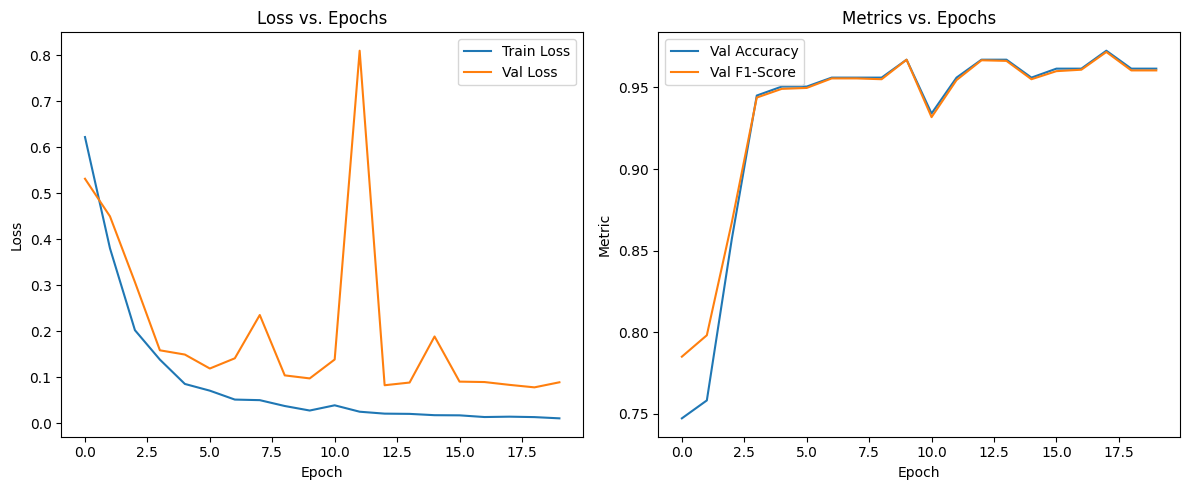

In [ ]:
import time
import matplotlib.pyplot as plt

print(f"Starting training for HybridForensicsNetV2 on DataSet AI ART...")

best_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Train
    train_loss = train_one_epoch(model_v2, train_loader_v2, criterion, optimizer, device, scaler)

    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = validate_model(model_v2, val_loader_v2, criterion, device)

    epoch_time = time.time() - epoch_start_time

    # Log history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | "
          f"Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f} | Time: {epoch_time:.1f}s")

    # Save the best model based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model_v2.state_dict(), model_save_path_v2)
        print(f"  -> New best model saved with F1: {val_f1:.4f} at {model_save_path_v2}")

print(f"\nTraining complete. Best V2 model saved to {model_save_path_v2} with F1: {best_f1:.4f}")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy')
plt.plot(history['val_f1'], label='Val F1-Score')
plt.legend()
plt.title('Metrics vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')

plt.tight_layout()
plot_save_path = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_training_plots.png")
plt.savefig(plot_save_path)
print(f"Training plots saved to {plot_save_path}")
plt.show()

Cell 11: Final Evaluation and Random Image Test
This cell loads your best saved model, runs a final evaluation, and lets you upload your own images to test.

Loading best model from /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth for final evaluation...
Model loaded successfully.
Running final validation to get metrics...


Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--- Final Validation Metrics ---
Accuracy: 0.9725
Precision: 0.9663
Recall: 0.9773
F1-Score: 0.9718
AUC: 0.9955

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.98      0.97      0.97        94
    Fake (1)       0.97      0.98      0.97        88

    accuracy                           0.97       182
   macro avg       0.97      0.97      0.97       182
weighted avg       0.97      0.97      0.97       182

Final report saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_final_report.txt
Confusion matrix plot saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_confusion_matrix.png


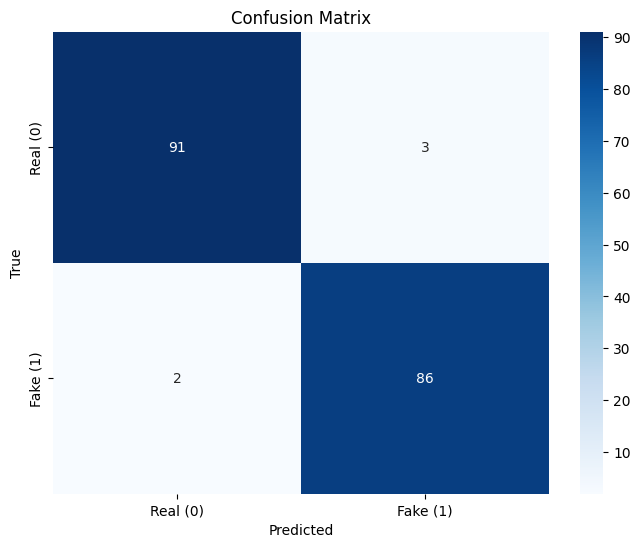


--- Test on Random Uploaded Images ---
Upload one or more images to test. Results will be saved in /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results


Saving ai-generated-7570920_1280.jpg to ai-generated-7570920_1280.jpg

Processing ai-generated-7570920_1280.jpg...
Prediction: AI-Generated (73.93%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_ai-generated-7570920_1280.jpg


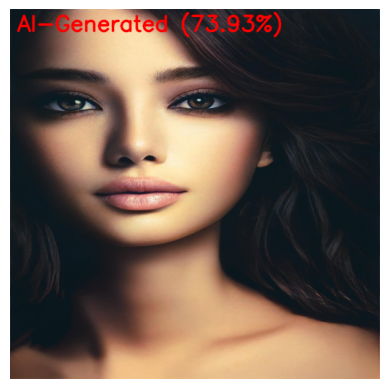

In [ ]:
# Cell 11: Final Evaluation and Random Image Test

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import cv2
import io # Make sure io is imported
import numpy as np # Make sure numpy is imported
from PIL import Image # Make sure Image is imported

# --- 1. Load the Best Model ---
print(f"Loading best model from {model_save_path_v2} for final evaluation...")
try:
    # We must first initialize the model class, then load the weights
    model_v2 = HybridForensicsNetV2().to(device)
    model_v2.load_state_dict(torch.load(model_save_path_v2))
    model_v2.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}. Please ensure Cell 9 ran successfully.")

# --- 2. Run Final Validation ---
print("Running final validation to get metrics...")
val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, all_labels, all_preds = validate_model(
    model_v2, val_loader_v2, criterion, device
)

print("--- Final Validation Metrics ---")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"AUC: {val_auc:.4f}")

report_str = classification_report(all_labels, all_preds, target_names=['Real (0)', 'Fake (1)'])
print("\nClassification Report:")
print(report_str)

# --- 3. Save Metrics to Drive ---
report_path = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_final_report.txt")
with open(report_path, 'w') as f:
    f.write(f"--- Final Validation Metrics for {model_save_path_v2} ---\n")
    f.write(f"Accuracy: {val_acc:.4f}\n")
    f.write(f"Precision: {val_prec:.4f}\n")
    f.write(f"Recall: {val_rec:.4f}\n")
    f.write(f"F1-Score: {val_f1:.4f}\n")
    f.write(f"AUC: {val_auc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report_str)
print(f"Final report saved to {report_path}")

# --- 4. Plot and Save Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
cm_path = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_confusion_matrix.png")
plt.savefig(cm_path)
print(f"Confusion matrix plot saved to {cm_path}")
plt.show()

# --- 5. Helper Function for Single Image Prediction ---
def predict_single_image(img_pil, model, transforms):
    model.eval()

    # --- Handle Transparency ---
    if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
        background = Image.new('RGB', img_pil.size, (255, 255, 255))
        background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
        img_pil = background
    else:
        img_pil = img_pil.convert('RGB')

    # --- Preprocess ---
    # Make sure all forensic functions are defined (run Cell 5)
    fft_img = apply_fft(img_pil).convert('L')
    wavelet_img = apply_wavelet_transform(img_pil).convert('L')
    ela_img = apply_ela(img_pil).convert('L')

    # Use the validation transforms (from Cell 9)
    rgb_tensor = transforms['rgb'](img_pil)
    fft_tensor = transforms['forensic'](fft_img)
    wavelet_tensor = transforms['forensic'](wavelet_img)
    ela_tensor = transforms['forensic'](ela_img)

    inputs = {
        'rgb': rgb_tensor.unsqueeze(0).to(device),
        'fft': fft_tensor.unsqueeze(0).to(device),
        'wavelet': wavelet_tensor.unsqueeze(0).to(device),
        'ela': ela_tensor.unsqueeze(0).to(device)
    }

    # --- Predict ---
    with torch.no_grad():
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
            output = model(inputs)
            score = torch.sigmoid(output).item()

    if score > 0.5:
        pred_label = f"AI-Generated ({(score*100):.2f}%)"
        color = (0, 0, 255) # Red in BGR
    else:
        pred_label = f"Real ({((1-score)*100):.2f}%)"
        color = (0, 255, 0) # Green in BGR

    return pred_label, color, score

# --- 6. Test on Uploaded Images ---
TEST_OUTPUT_DIR = os.path.join(WILDFAKE_OUTPUT_DIR, "random_test_results")
os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

print(f"\n--- Test on Random Uploaded Images ---")
print(f"Upload one or more images to test. Results will be saved in {TEST_OUTPUT_DIR}")
uploaded_files = files.upload()

if not uploaded_files:
    print("No files uploaded. Skipping random test.")
else:
    for filename, file_bytes in uploaded_files.items():
        try:
            print(f"\nProcessing {filename}...")
            img_pil = Image.open(io.BytesIO(file_bytes))

            # Get prediction
            pred_label, color, score = predict_single_image(img_pil, model_v2, val_transforms)

            print(f"Prediction: {pred_label}")

            # --- Save annotated image ---
            # Convert PIL to OpenCV format (RGB -> BGR)
            img_cv = cv2.cvtColor(np.array(img_pil.convert('RGB')), cv2.COLOR_RGB2BGR)
            img_cv = cv2.resize(img_cv, (512, 512), interpolation=cv2.INTER_AREA)

            # Add text
            cv2.putText(img_cv, pred_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, color, 2, cv2.LINE_AA)

            # Save to Drive
            save_path = os.path.join(TEST_OUTPUT_DIR, f"predicted_{filename}")
            cv2.imwrite(save_path, img_cv)
            print(f"Result saved to {save_path}")

            # Display in Colab
            plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")


Loading best model from /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_hybrid_model_best.pth for final evaluation...
Model loaded successfully.
Running final validation on the entire validation set...


Validation:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



--- Final Validation Metrics ---
Accuracy: 0.9725
Precision: 0.9663
Recall: 0.9773
F1-Score: 0.9718
AUC: 0.9955

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.98      0.97      0.97        94
    Fake (1)       0.97      0.98      0.97        88

    accuracy                           0.97       182
   macro avg       0.97      0.97      0.97       182
weighted avg       0.97      0.97      0.97       182

Final report saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_final_report.txt
Confusion matrix plot saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/wildfake_confusion_matrix.png


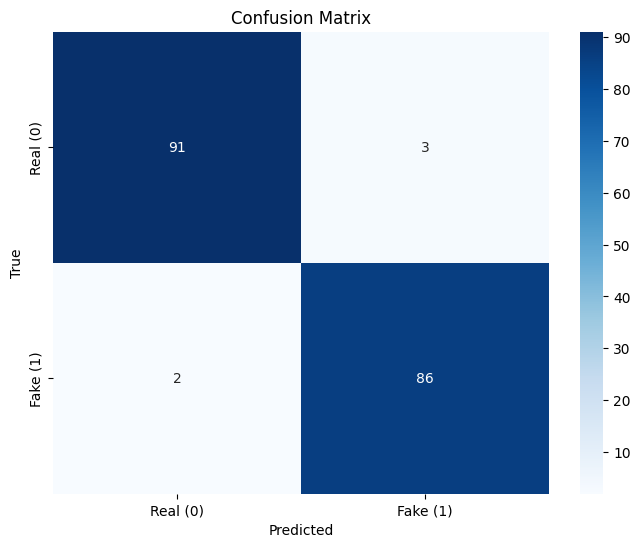


--- Testing on 25 Random Validation Images ---
Annotated results will be saved in /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results

---------------------------------
Processing: images18.jpg
True Label: Real (0)
Prediction: Real (99.98%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_images18.jpg


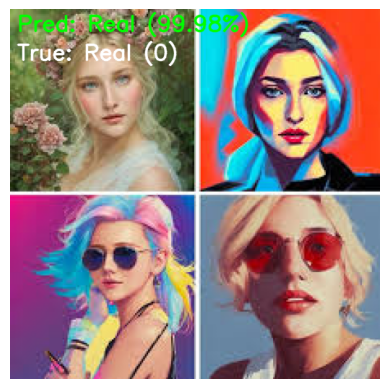


---------------------------------
Processing: 5552488_6d18_2.jpg
True Label: Real (0)
Prediction: Real (99.93%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_5552488_6d18_2.jpg


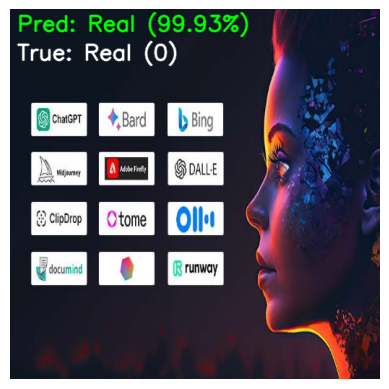


---------------------------------
Processing: snapshot_20230310.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.76%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_snapshot_20230310.jpg


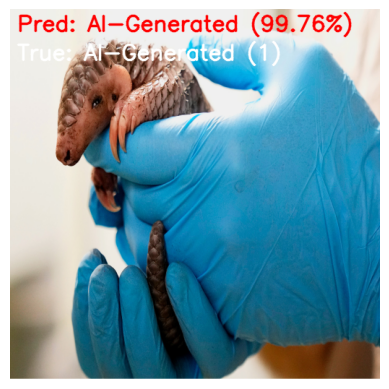


---------------------------------
Processing: daniel-norton-portrait-photography-CLOSE.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.95%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_daniel-norton-portrait-photography-CLOSE.jpg


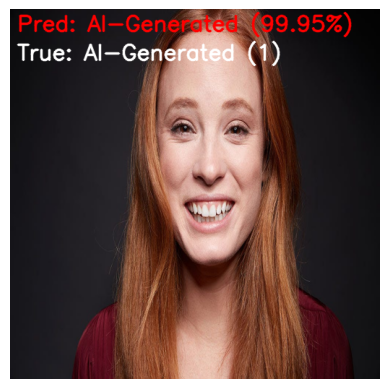


---------------------------------
Processing: autumn-walk-1800329209.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.90%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_autumn-walk-1800329209.jpg


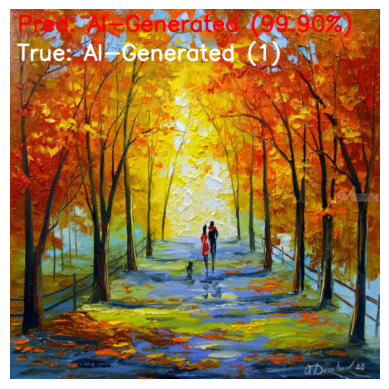


---------------------------------
Processing: serene-natural-background-depicting-peaceful-landscape-scenery-ai-generated_523886-7267.jpg
True Label: Real (0)
Prediction: Real (99.54%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_serene-natural-background-depicting-peaceful-landscape-scenery-ai-generated_523886-7267.jpg


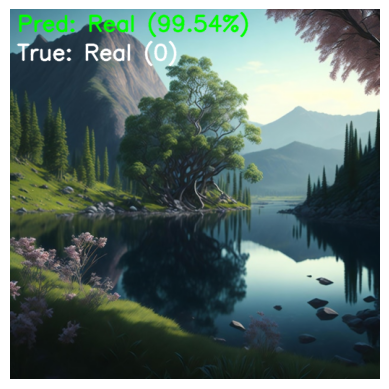


---------------------------------
Processing: images.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.95%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_images.jpg


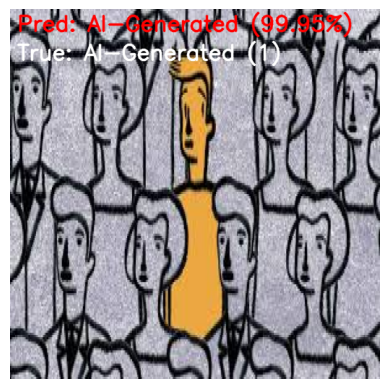


---------------------------------
Processing: people-movement_740563843.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.80%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_people-movement_740563843.jpg


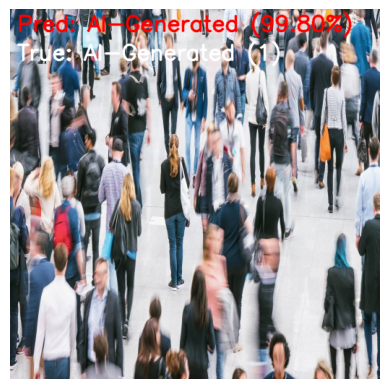


---------------------------------
Processing: BabyAnimals.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (93.46%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_BabyAnimals.jpg


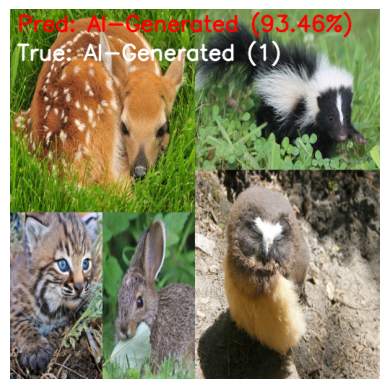


---------------------------------
Processing: images88.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (98.34%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_images88.jpg


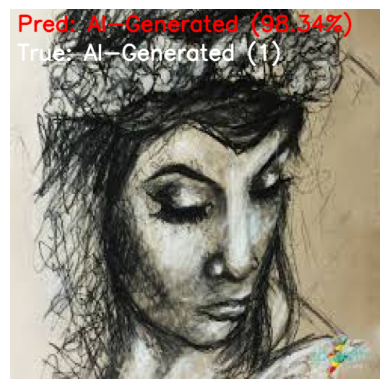


---------------------------------
Processing: 2022-11-10-image-12.jpg
True Label: Real (0)
Prediction: Real (99.85%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_2022-11-10-image-12.jpg


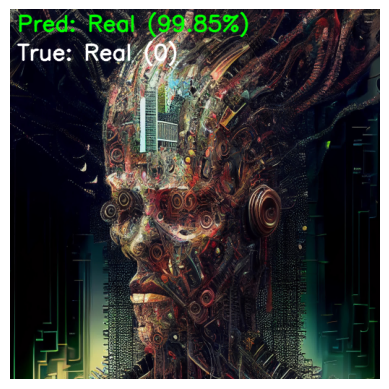


---------------------------------
Processing: images52.jpg
True Label: Real (0)
Prediction: Real (99.95%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_images52.jpg


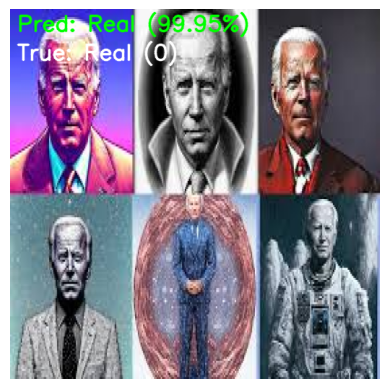


---------------------------------
Processing: 4-23-4-22-8-4-13m.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.85%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_4-23-4-22-8-4-13m.jpg


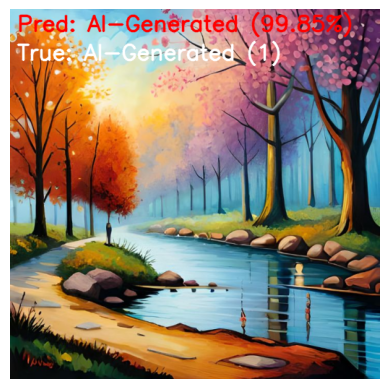


---------------------------------
Processing: mountainpygmypossum_science_BCDJ6K.jpg
True Label: AI-Generated (1)
Prediction: Real (76.54%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_mountainpygmypossum_science_BCDJ6K.jpg


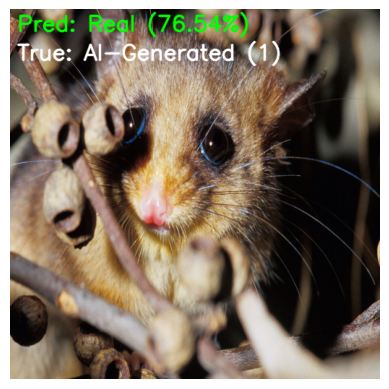


---------------------------------
Processing: 2023spring-ai-wildlife.1024-2.jpg
True Label: Real (0)
Prediction: Real (99.55%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_2023spring-ai-wildlife.1024-2.jpg


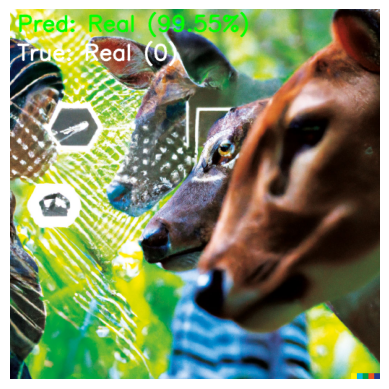


---------------------------------
Processing: 5-23-7-23-8-53-6m.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.85%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_5-23-7-23-8-53-6m.jpg


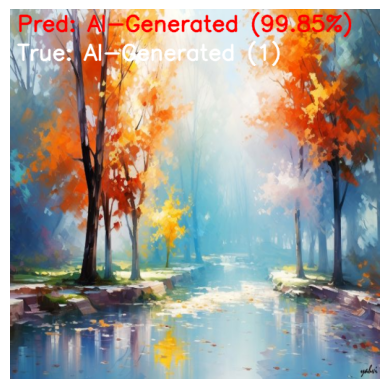


---------------------------------
Processing: 0ogZjy9KvWg2elv-I.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.66%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_0ogZjy9KvWg2elv-I.jpg


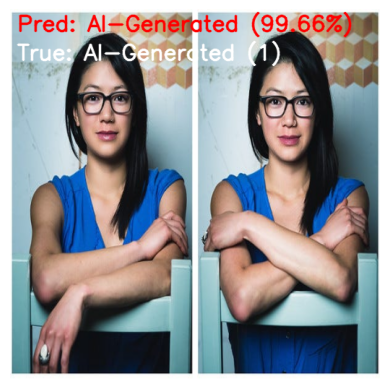


---------------------------------
Processing: 0182.png
True Label: AI-Generated (1)
Prediction: AI-Generated (89.55%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_0182.png


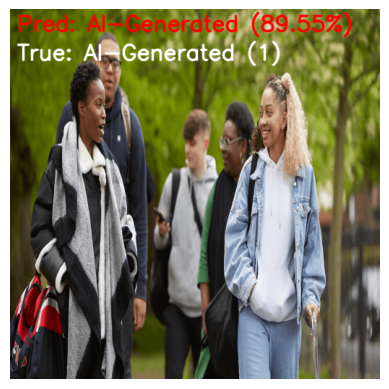


---------------------------------
Processing: 210604151110-02-platon-nft-iris-series-restricted.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (97.56%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_210604151110-02-platon-nft-iris-series-restricted.jpg


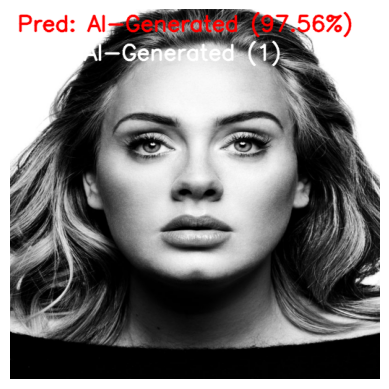


---------------------------------
Processing: The-Lensa-app-generates-AI-art-but-at-what-cost_-Photo-courtesy-of-Lensa-app.-900x900.jpg
True Label: Real (0)
Prediction: Real (99.55%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_The-Lensa-app-generates-AI-art-but-at-what-cost_-Photo-courtesy-of-Lensa-app.-900x900.jpg


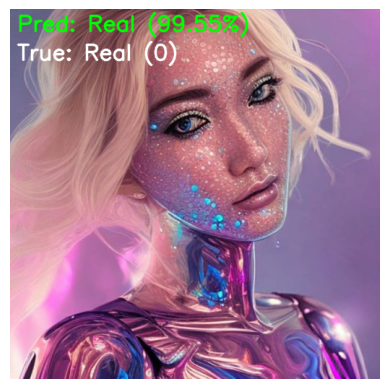


---------------------------------
Processing: mhachman_a_castle_on_an_asteroid_floating_through_space_2315526d-252b-40df-9a6d-eeb00aed612f.png
True Label: Real (0)
Prediction: Real (99.92%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_mhachman_a_castle_on_an_asteroid_floating_through_space_2315526d-252b-40df-9a6d-eeb00aed612f.png


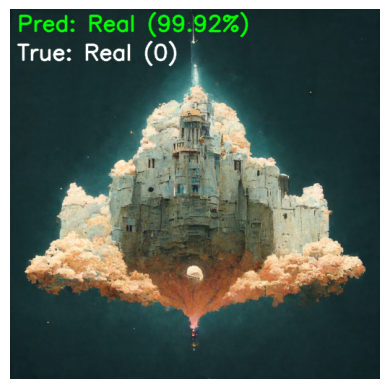


---------------------------------
Processing: cute-baby-animals-at-australia-zoo.thumb.800.480.png
True Label: AI-Generated (1)
Prediction: AI-Generated (99.95%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_cute-baby-animals-at-australia-zoo.thumb.800.480.png


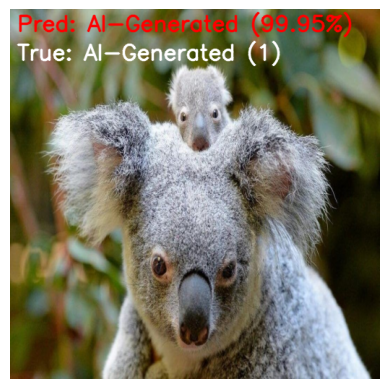


---------------------------------
Processing: 5c09c4dc82dc441dfb26975fe8dc1634.jpg
True Label: AI-Generated (1)
Prediction: AI-Generated (99.95%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_5c09c4dc82dc441dfb26975fe8dc1634.jpg


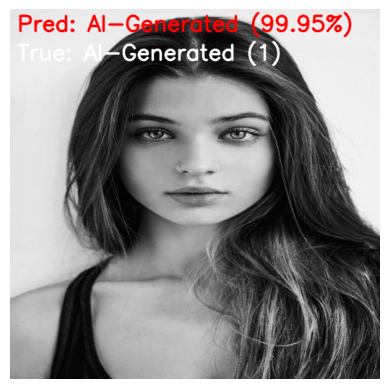


---------------------------------
Processing: GANimal-1280x540.jpg
True Label: Real (0)
Prediction: Real (84.94%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_GANimal-1280x540.jpg


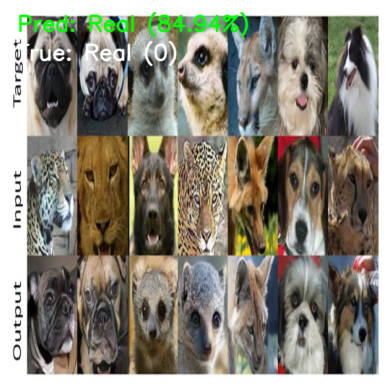


---------------------------------
Processing: 394d68ba91ee4f49d400034d8d487997.jpg
True Label: Real (0)
Prediction: Real (99.71%)
Result saved to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/random_test_results/predicted_394d68ba91ee4f49d400034d8d487997.jpg


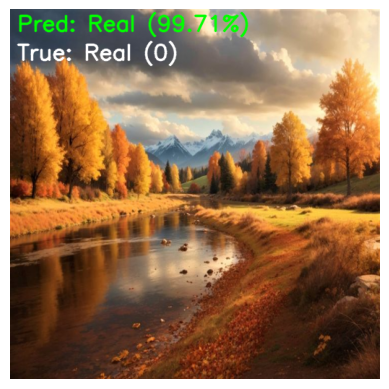


--- All evaluations complete! ---


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import io
import numpy as np
from PIL import Image
import random # Needed for the random test

# --- 1. Load the Best Model ---
print(f"Loading best model from {model_save_path_v2} for final evaluation...")
try:
    # We must first initialize the model class, then load the weights
    model_v2 = HybridForensicsNetV2().to(device)
    # Load the saved weights (state_dict)
    model_v2.load_state_dict(torch.load(model_save_path_v2, map_location=device))
    model_v2.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}. Please ensure the model file exists from Cell 8.")

# --- 2. Run Final Validation ---
print("Running final validation on the entire validation set...")
val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, all_labels, all_preds = validate_model(
    model_v2, val_loader_v2, criterion, device
)

print("\n--- Final Validation Metrics ---")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"AUC: {val_auc:.4f}")

report_str = classification_report(all_labels, all_preds, target_names=['Real (0)', 'Fake (1)'])
print("\nClassification Report:")
print(report_str)

# --- 3. Save Metrics to Drive ---
report_path = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_final_report.txt")
with open(report_path, 'w') as f:
    f.write(f"--- Final Validation Metrics for {model_save_path_v2} ---\n")
    f.write(f"Accuracy: {val_acc:.4f}\n")
    f.write(f"Precision: {val_prec:.4f}\n")
    f.write(f"Recall: {val_rec:.4f}\n")
    f.write(f"F1-Score: {val_f1:.4f}\n")
    f.write(f"AUC: {val_auc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report_str)
print(f"Final report saved to {report_path}")

# --- 4. Plot and Save Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
cm_path = os.path.join(WILDFAKE_OUTPUT_DIR, "wildfake_confusion_matrix.png")
plt.savefig(cm_path)
print(f"Confusion matrix plot saved to {cm_path}")
plt.show()

# --- 5. Helper Function for Single Image Prediction ---
def predict_single_image(img_pil, model, transforms):
    model.eval()

    # --- Handle Transparency ---
    if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
        background = Image.new('RGB', img_pil.size, (255, 255, 255))
        background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
        img_pil = background
    else:
        img_pil = img_pil.convert('RGB')

    # --- Preprocess ---
    fft_img = apply_fft(img_pil).convert('L')
    wavelet_img = apply_wavelet_transform(img_pil).convert('L')
    ela_img = apply_ela(img_pil).convert('L')

    # Use the validation transforms
    rgb_tensor = transforms['rgb'](img_pil)
    fft_tensor = transforms['forensic'](fft_img)
    wavelet_tensor = transforms['forensic'](wavelet_img)
    ela_tensor = transforms['forensic'](ela_img)

    inputs = {
        'rgb': rgb_tensor.unsqueeze(0).to(device),
        'fft': fft_tensor.unsqueeze(0).to(device),
        'wavelet': wavelet_tensor.unsqueeze(0).to(device),
        'ela': ela_tensor.unsqueeze(0).to(device)
    }

    # --- Predict ---
    with torch.no_grad():
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
            output = model(inputs)
            score = torch.sigmoid(output).item()

    if score > 0.5:
        pred_label = f"AI-Generated ({(score*100):.2f}%)"
        color = (0, 0, 255) # Red in BGR
    else:
        pred_label = f"Real ({((1-score)*100):.2f}%)"
        color = (0, 255, 0) # Green in BGR

    return pred_label, color, score

# --- 6. Test on 25 Random Validation Images (UPGRADED) ---
TEST_OUTPUT_DIR = os.path.join(WILDFAKE_OUTPUT_DIR, "random_test_results")
os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

print(f"\n--- Testing on 25 Random Validation Images ---")
print(f"Annotated results will be saved in {TEST_OUTPUT_DIR}")

# Get the file paths and labels from the validation subset
# We use val_dataset_v2 (defined in Cell 7) and val_indices (also from Cell 7)
try:
    val_image_data = [val_dataset_v2.all_images[i] for i in val_indices]
    random.shuffle(val_image_data)
except NameError:
    print("Error: Could not find 'val_dataset_v2' or 'val_indices'.")
    print("Please make sure you have run Cell 7 (Model Training Configuration) first.")
    val_image_data = [] # empty list to prevent crash

# Select 25 images to test
test_images = val_image_data[:25]

if not test_images:
    print("No validation images found to test.")
else:
    for img_path, true_label in test_images:
        try:
            filename = os.path.basename(img_path)
            true_label_str = "Real (0)" if true_label == 0 else "AI-Generated (1)"

            print(f"\n---------------------------------")
            print(f"Processing: {filename}")
            print(f"True Label: {true_label_str}")

            img_pil = Image.open(img_path)

            # Get prediction
            pred_label, color, score = predict_single_image(img_pil, model_v2, val_transforms)
            print(f"Prediction: {pred_label}")

            # --- Save annotated image ---
            # Convert PIL to OpenCV format (RGB -> BGR)
            img_cv = cv2.cvtColor(np.array(img_pil.convert('RGB')), cv2.COLOR_RGB2BGR)
            img_cv = cv2.resize(img_cv, (512, 512), interpolation=cv2.INTER_AREA)

            # Add True Label Text (White)
            cv2.putText(img_cv, f"True: {true_label_str}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (255, 255, 255), 2, cv2.LINE_AA)
            # Add Predicted Label Text (Green/Red)
            cv2.putText(img_cv, f"Pred: {pred_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, color, 2, cv2.LINE_AA)

            # Save to Drive
            save_path = os.path.join(TEST_OUTPUT_DIR, f"predicted_{filename}")
            cv2.imwrite(save_path, img_cv)
            print(f"Result saved to {save_path}")

            # Display in Colab
            plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("\n--- All evaluations complete! ---")

In [ ]:
# Cell 10: Failure Analysis
print("--- Starting Failure Analysis (Misclassification Test) ---")

FAILURE_DIR = os.path.join(WILDFAKE_OUTPUT_DIR, "failure_analysis")
os.makedirs(FAILURE_DIR, exist_ok=True)
print(f"Saving misclassified images to {FAILURE_DIR}...")

try:
    # Get the ordered list of image paths and labels from the validation set
    # We use val_indices (from Cell 7) to get the *exact* order used by the loader
    val_image_data = [val_dataset_v2.all_images[i] for i in val_indices]

    # all_labels and all_preds were generated by val_loader_v2 in Cell 9
    # Since val_loader_v2 has shuffle=False, these lists match val_image_data

    mismatches = 0
    correct_matches = 0

    # Zip together the image data (path, true_label) with the predicted labels
    for (img_path, true_label), pred_label in zip(val_image_data, all_preds):

        # Check if the prediction was wrong
        if true_label != pred_label:
            mismatches += 1

            # --- Annotate and Save the Failed Image ---
            img_pil = Image.open(img_path).convert("RGB")
            img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
            img_cv = cv2.resize(img_cv, (512, 512), interpolation=cv2.INTER_AREA)

            true_str = "Real" if true_label == 0 else "AI-Generated"
            pred_str = "Real" if int(pred_label) == 0 else "AI-Generated"

            # Add text
            cv2.putText(img_cv, f"True: {true_str}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2, cv2.LINE_AA) # Green for True
            cv2.putText(img_cv, f"Predicted: {pred_str}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 0, 255), 2, cv2.LINE_AA) # Red for Predicted

            filename = os.path.basename(img_path)
            save_path = os.path.join(FAILURE_DIR, f"MISMATCH_{filename}")
            cv2.imwrite(save_path, img_cv)
        else:
            correct_matches += 1

    print(f"\n--- Failure Analysis Complete ---")
    print(f"Total validation images: {len(all_preds)}")
    print(f"Correct predictions: {correct_matches}")
    print(f"Misclassifications: {mismatches}")
    print(f"Found and saved {mismatches} misclassified images to {FAILURE_DIR}")

except NameError as e:
    print(f"Error: Could not find variables from Cell 7 or Cell 9.")
    print(f"Please re-run Cell 7 and Cell 9 before running this cell.")
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

--- Starting Failure Analysis (Misclassification Test) ---
Saving misclassified images to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/failure_analysis...


/tmp/ipython-input-3622595628.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_str = "Real" if int(pred_label) == 0 else "AI-Generated"



--- Failure Analysis Complete ---
Total validation images: 182
Correct predictions: 177
Misclassifications: 5
Found and saved 5 misclassified images to /content/drive/MyDrive/AI gen Images/archive/WildFake_Output/failure_analysis


In [12]:
# Cell 12: Sanity Check on Training Data
print("--- Starting Sanity Check on Training Data ---")

try:
    # Create a new loader for the *training* data
    # IMPORTANT: We use val_transforms (no augmentation) to get a clean test
    train_subset_for_test = Subset(train_dataset_v2, train_indices)

    # We can use a smaller subset if it's too slow, e.g., train_indices[:2000]
    # For now, we'll use the whole training set.

    train_loader_for_test = DataLoader(
        train_subset_for_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=(device.type == 'cuda')
    )

    print("Running evaluation on the training set...")
    # Run the same validation function, but on the training data
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_auc, _, _ = validate_model(
        model_v2, train_loader_for_test, criterion, device
    )

    print("\n--- Training Set Sanity Check Metrics ---")
    print(f"Accuracy: {tr_acc:.4f}")
    print(f"Precision: {tr_prec:.4f}")
    print(f"Recall: {tr_rec:.4f}")
    print(f"F1-Score: {tr_f1:.4f}")
    print(f"AUC: {tr_auc:.4f}")
    print("\nNote: This accuracy should be very high (e.g., 99-100%).")
    print("If it's high but validation accuracy is low, you are overfitting.")

except NameError as e:
    print(f"Error: Could not find variables from Cell 7 (like train_indices).")
    print(f"Please re-run Cell 7 first.")
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

--- Starting Sanity Check on Training Data ---
Running evaluation on the training set...



--- Training Set Sanity Check Metrics ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC: 1.0000

Note: This accuracy should be very high (e.g., 99-100%).
If it's high but validation accuracy is low, you are overfitting.
